In [1]:
import pickle
import numpy as np

In [2]:
%pip install transformers datasets torch evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
%pip install -U huggingface_hub


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with open("/content/drive/MyDrive/Graduation Project - CSE4297/Dataset for ML Project/Hugging Face Dataset Format/90_5_5_binary_hugging_face_dataset.pkl","rb") as f:
    splitted_dataset=pickle.load(f)

In [6]:
splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'Haklar', 'Kararın Bağlantı Linki', 'Başvuru Konusu', 'labels'],
        num_rows: 11957
    })
    test: Dataset({
        features: ['text', 'Haklar', 'Kararın Bağlantı Linki', 'Başvuru Konusu', 'labels'],
        num_rows: 665
    })
    dev: Dataset({
        features: ['text', 'Haklar', 'Kararın Bağlantı Linki', 'Başvuru Konusu', 'labels'],
        num_rows: 664
    })
})

In [12]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

In [14]:
tokenized_kararlar = splitted_dataset.map(preprocess_function, batched=True)
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/11957 [00:00<?, ? examples/s]

Map:   0%|          | 0/665 [00:00<?, ? examples/s]

Map:   0%|          | 0/664 [00:00<?, ? examples/s]

In [15]:
import evaluate
f1_metric=evaluate.load("f1",average="macro",zero_division=0)
precision_metric=evaluate.load("precision",average="macro",zero_division=0)
recall_metric=evaluate.load("recall",average="macro",zero_division=0)
accuracy_metric = evaluate.load("accuracy")

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    # Unpack predictions and labels
    logits, labels = eval_pred
    # Get the predicted class by taking the argmax
    predictions = logits.argmax(axis=-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    # Calculate macro precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")

    return {
        "accuracy": accuracy,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1,
    }

In [20]:
label2id={'Ret': 0, 'İhlal': 1}
id2label = {value: key for key, value in label2id.items()}

In [10]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer,AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-cased", num_labels=2, id2label=id2label, label2id=label2id
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [20]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Graduation Project - CSE4297/Dataset for ML Project/Training Code for DL/aym-bert-turkish-base",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    save_total_limit=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    push_to_hub=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_kararlar["train"],
    eval_dataset=tokenized_kararlar["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-9e383b60d846>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,0.519828,0.709337,0.710765,0.709681,0.709046
2,No log,0.453181,0.768072,0.774207,0.768734,0.767049
3,0.513100,0.450247,0.780120,0.781877,0.779749,0.779609
4,0.513100,0.449203,0.789157,0.789146,0.789167,0.789149


TrainOutput(global_step=748, training_loss=0.4661701630781041, metrics={'train_runtime': 930.2083, 'train_samples_per_second': 51.416, 'train_steps_per_second': 0.804, 'total_flos': 1.258407555575808e+16, 'train_loss': 0.4661701630781041, 'epoch': 4.0})

In [21]:
import json
with open(trainer.args.output_dir + "/aym-bert-turkish-base","w") as f:
    test_results={}
    test_results=trainer.evaluate(tokenized_kararlar['test'])
    json.dump(test_results,f)
    print(test_results)


{'eval_loss': 0.43222329020500183, 'eval_accuracy': 0.8015037593984963, 'eval_macro_precision': 0.8011997742458172, 'eval_macro_recall': 0.8002159435280455, 'eval_macro_f1': 0.800590640617901, 'eval_runtime': 4.3412, 'eval_samples_per_second': 153.185, 'eval_steps_per_second': 2.534, 'epoch': 4.0}


In [17]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer,AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/Graduation Project - CSE4297/Dataset for ML Project/Training Code for DL/aym-bert-turkish-base/checkpoint-748", num_labels=2, id2label=id2label, label2id=label2id
)
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
test_results=trainer.evaluate(tokenized_kararlar['test'])
test_results

<ipython-input-17-d817e00621eb>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'eval_loss': 0.4322233498096466,
 'eval_model_preparation_time': 0.0035,
 'eval_accuracy': 0.8015037593984963,
 'eval_macro_precision': 0.8011997742458172,
 'eval_macro_recall': 0.8002159435280455,
 'eval_macro_f1': 0.800590640617901,
 'eval_runtime': 5.9511,
 'eval_samples_per_second': 111.743,
 'eval_steps_per_second': 14.115}

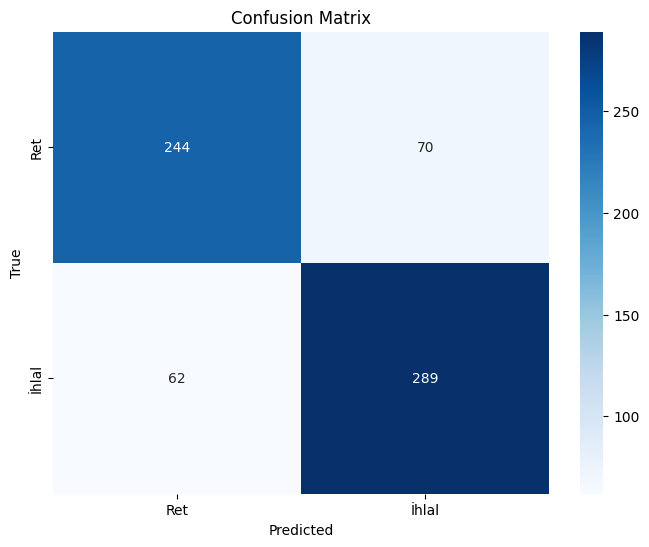

Accuracy: 0.8015037593984963
Precision: 0.8014119902958007
Recall: 0.8015037593984963
F1 Score: 0.8013414271708348

Classification Report:

              precision    recall  f1-score   support

         Ret       0.80      0.78      0.79       314
       İhlal       0.81      0.82      0.81       351

    accuracy                           0.80       665
   macro avg       0.80      0.80      0.80       665
weighted avg       0.80      0.80      0.80       665



In [21]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define checkpoint and parameters
checkpoint = "/content/drive/MyDrive/Graduation Project - CSE4297/Dataset for ML Project/Training Code for DL/aym-bert-turkish-base/checkpoint-748"
num_labels = 2

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Make predictions on the evaluation dataset
predictions = trainer.predict(tokenized_kararlar["test"])
logits = predictions.predictions
true_labels = predictions.label_ids
predicted_labels = np.argmax(logits, axis=-1)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(id2label.values()), yticklabels=list(id2label.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Generate classification report
classification_rep = classification_report(true_labels, predicted_labels, target_names=list(id2label.values()))

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n")
print(classification_rep)

# Save metrics to a .txt file
with open("/content/drive/MyDrive/Graduation Project - CSE4297/Dataset for ML Project/Training Code for DL/model_metrics.txt", "w") as file:
    file.write("Model Evaluation Metrics\n")
    file.write("=========================\n\n")
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"Precision: {precision:.4f}\n")
    file.write(f"Recall: {recall:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n\n")
    file.write("Classification Report:\n")
    file.write(classification_rep)
    file.write("\n\nConfusion Matrix:\n")
    file.write(np.array2string(cm))
